## Project info

In this project I will try to use Naive Bayes approach to predict Credit Score

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp
import scipy.stats as ss
from sklearn.metrics import accuracy_score, balanced_accuracy_score

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Data Info

Dataset is downloaded from [Kaggle dataset](https://www.kaggle.com/datasets/clkmuhammed/creditscoreclassification)

It has already been cleaned, so we can focus on the model construction without much of EDA

In [2]:
base = 'C:/Users/anton/OneDrive/data_science/models_from_scratch/datasets/'
data = pd.read_csv(base + 'credit_score_train.csv')
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [3]:
data.drop(['ID', 'Customer_ID', 'SSN', 'Name'], axis=1, inplace=True)

In [4]:
data.columns = data.columns.str.lower()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   month                     100000 non-null  int64  
 1   age                       100000 non-null  float64
 2   occupation                100000 non-null  object 
 3   annual_income             100000 non-null  float64
 4   monthly_inhand_salary     100000 non-null  float64
 5   num_bank_accounts         100000 non-null  float64
 6   num_credit_card           100000 non-null  float64
 7   interest_rate             100000 non-null  float64
 8   num_of_loan               100000 non-null  float64
 9   type_of_loan              100000 non-null  object 
 10  delay_from_due_date       100000 non-null  float64
 11  num_of_delayed_payment    100000 non-null  float64
 12  changed_credit_limit      100000 non-null  float64
 13  num_credit_inquiries      100000 non-null  fl

### Numeric data

In [6]:
data.select_dtypes(include='number').head().T

,0,1,2,3,4
month,1.00,2.00,3.00,4.00,5.00
age,23.00,23.00,23.00,23.00,23.00
annual_income,19114.12,19114.12,19114.12,19114.12,19114.12
monthly_inhand_salary,1824.84,1824.84,1824.84,1824.84,1824.84
num_bank_accounts,3.00,3.00,3.00,3.00,3.00
num_credit_card,4.00,4.00,4.00,4.00,4.00
interest_rate,3.00,3.00,3.00,3.00,3.00
num_of_loan,4.00,4.00,4.00,4.00,4.00
delay_from_due_date,3.00,3.00,3.00,5.00,6.00
num_of_delayed_payment,7.00,4.00,7.00,4.00,4.00


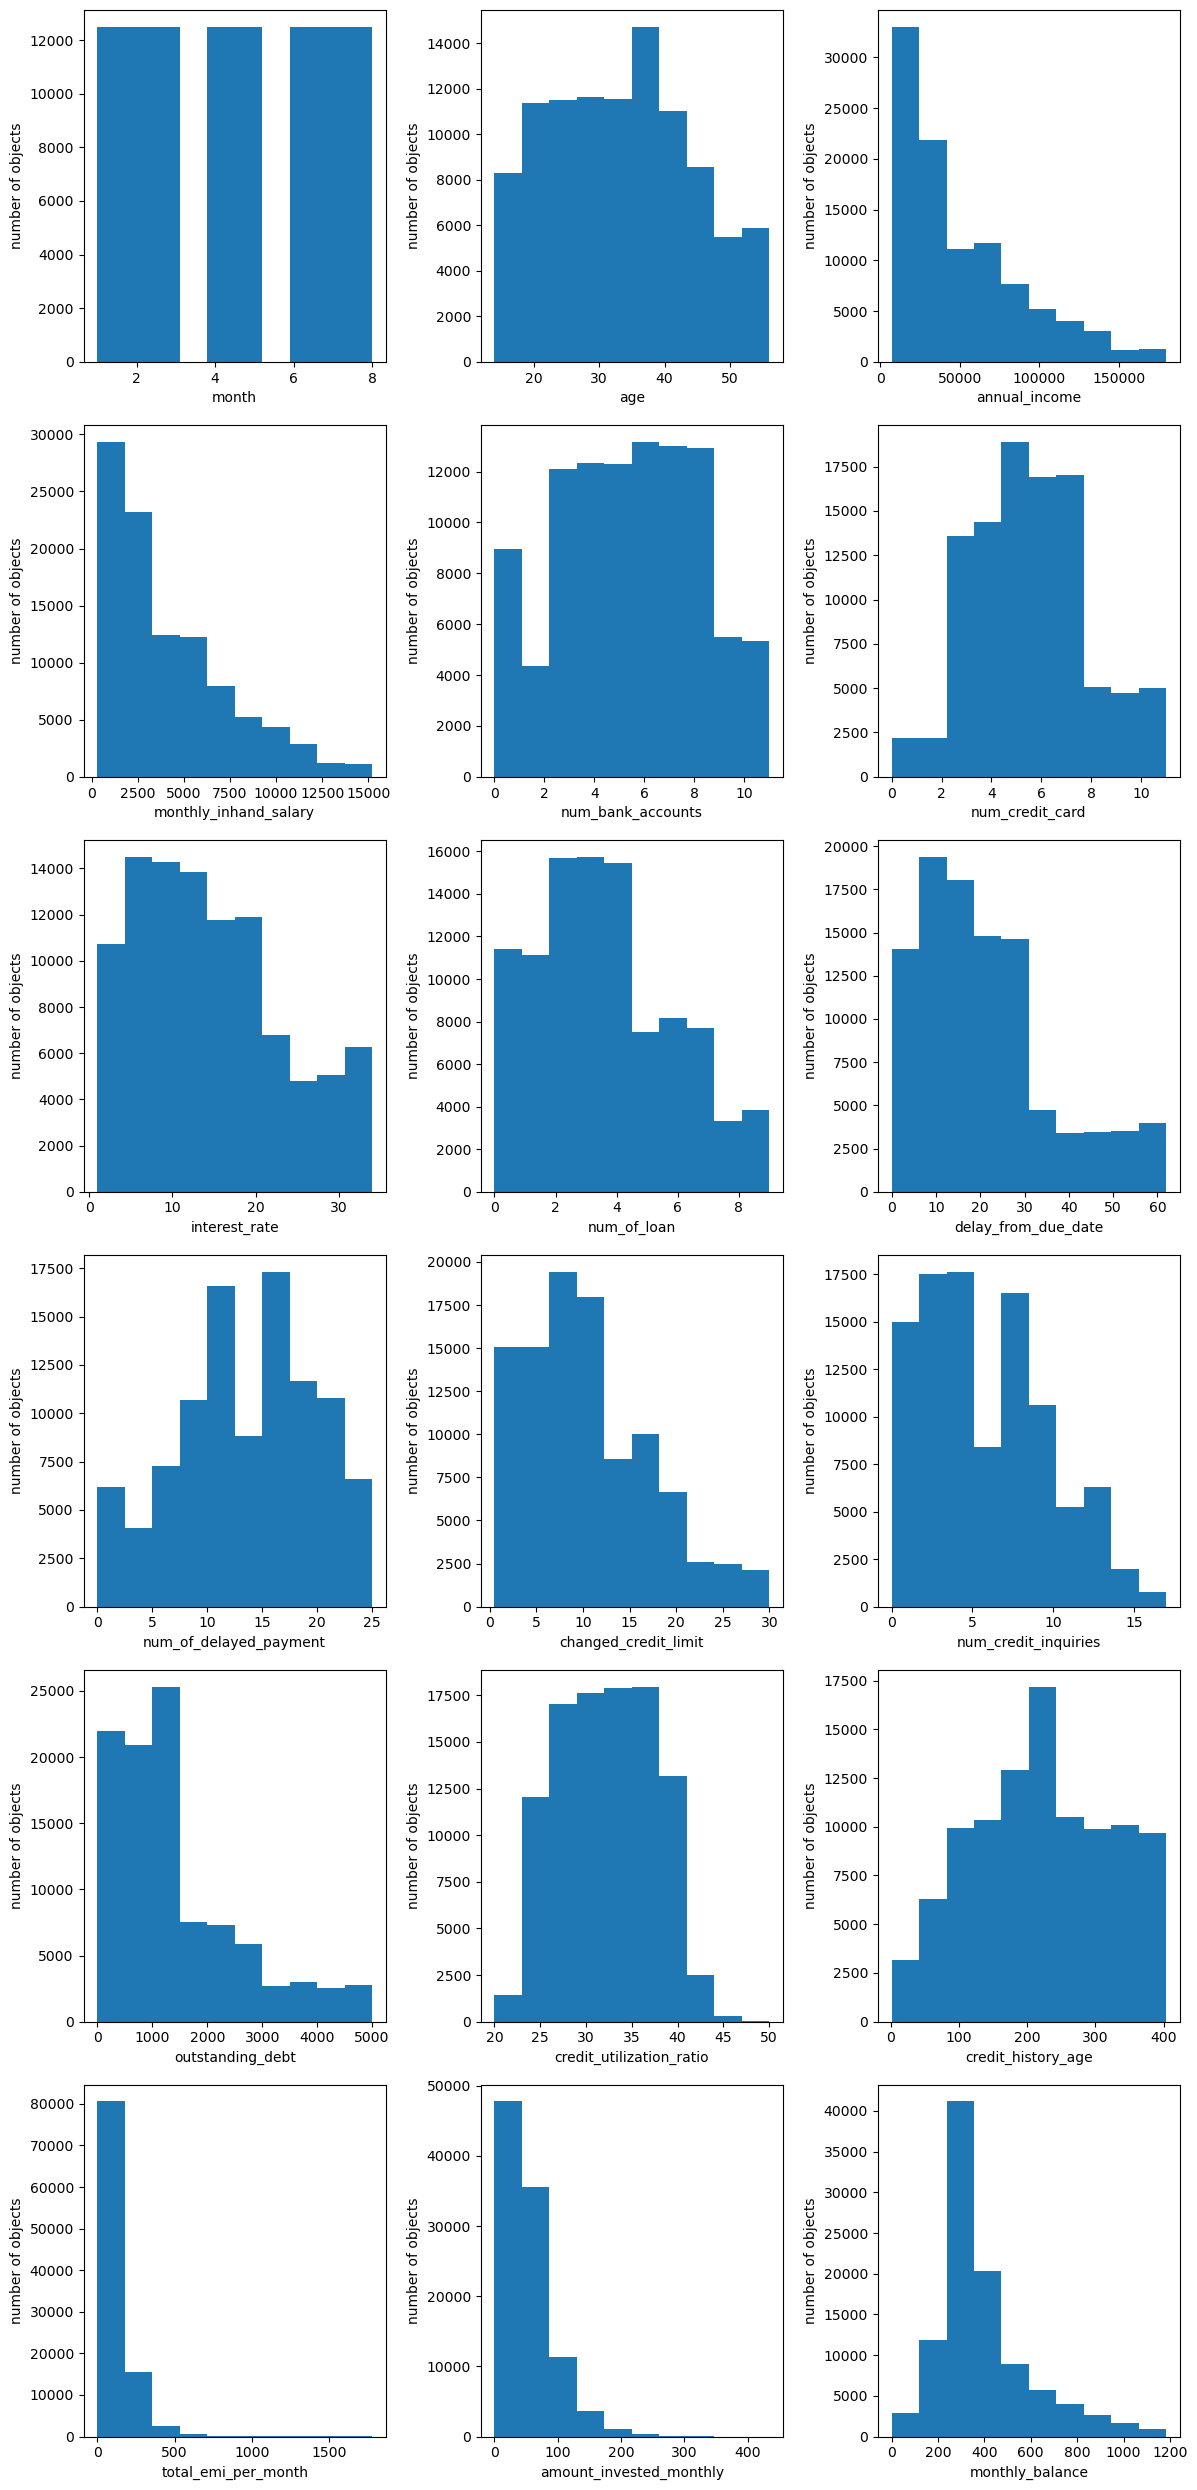

In [7]:
num_cols = data.select_dtypes(include='number').columns

fig, axes = plt.subplots(
    len(num_cols) // 3 + int(bool(len(num_cols) % 3)),
    3,
    figsize=(12, 25)
)

for i, axis in enumerate(axes.flat):
    if i < len(num_cols):
        axis.hist(data.select_dtypes(include='number').values[:, i])
        # axis.set_title(data.select_dtypes(include='number').columns[i])
        axis.set_xlabel(data.select_dtypes(include='number').columns[i])
        axis.set_ylabel('number of objects')

plt.tight_layout()
plt.show()

### Categorical data

In [8]:
data.select_dtypes(include='object').head()

,occupation,type_of_loan,credit_mix,payment_of_min_amount,payment_behaviour,credit_score
0,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,High_spent_Small_value_payments,Good
1,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,Low_spent_Large_value_payments,Good
2,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,Low_spent_Medium_value_payments,Good
3,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,Low_spent_Small_value_payments,Good
4,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,High_spent_Medium_value_payments,Good


In [9]:
cat_cols = data.select_dtypes(include='object').columns

for col in cat_cols:
    df = data[col].value_counts().to_frame('Number of elements')
    df['Ratio'] = data[col].value_counts(normalize=True)
    display(df)
    print()

,Number of elements,Ratio
occupation,,
Lawyer,7096,0.07
Engineer,6864,0.07
Architect,6824,0.07
Mechanic,6776,0.07
Scientist,6744,0.07
Accountant,6744,0.07
Developer,6720,0.07
Media_Manager,6720,0.07
Teacher,6672,0.07


,Number of elements,Ratio
type_of_loan,,
No Data,11408,0.11
not specified,1408,0.01
credit-builder loan,1280,0.01
personal loan,1272,0.01
debt consolidation loan,1264,0.01
...,...,...
"not specified,mortgage loan,auto loan,payday loan",8,0.00
"payday loan,mortgage loan,debt consolidation loan,student loan",8,0.00
"debt consolidation loan,auto loan,personal loan,debt consolidation loan,student loan,credit-builder loan",8,0.00


,Number of elements,Ratio
credit_mix,,
Standard,45848,0.46
Good,30384,0.30
Bad,23768,0.24


,Number of elements,Ratio
payment_of_min_amount,,
Yes,52326,0.52
No,35667,0.36
NM,12007,0.12


,Number of elements,Ratio
payment_behaviour,,
Low_spent_Small_value_payments,28580,0.29
High_spent_Medium_value_payments,18988,0.19
Low_spent_Medium_value_payments,14962,0.15
High_spent_Large_value_payments,14639,0.15
High_spent_Small_value_payments,12043,0.12
Low_spent_Large_value_payments,10788,0.11


,Number of elements,Ratio
credit_score,,
Standard,53174,0.53
Poor,28998,0.29
Good,17828,0.18


In categorical data we'll need to work with `type of loan` column - we can get dummy features for every unique type of loan

## Classifier implementation

### First attempt, numeric data only

As the first attempt we'll try to use only numerical features with only Normal distribution

In [10]:
data.select_dtypes(include='number').columns

Index(['month', 'age', 'annual_income', 'monthly_inhand_salary',
       'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
       'credit_history_age', 'total_emi_per_month', 'amount_invested_monthly',
       'monthly_balance'],
      dtype='object')

In [11]:
X = data[['annual_income', 'age', 'num_of_delayed_payment']].values
y = data['credit_score'].values

Basis: predict the probability of observing a `y` with given `X`
$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)} \\
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x}_i)
$$

Where:
$$
P(\mathbf{x}_i|y_i = C_k) = \prod_{j = 1}^{n_{features}}P(\mathbf{x}_i^{j}|y_i = C_k) \\
\log P(\mathbf{x}_i|y_i = C_k) = \sum_{j = 1}^{n_{features}}(\log P(\mathbf{x}_i^{j}|y_i = C_k)) \\
$$
and
$$
P(\mathbf{x}_i) = \sum_{k=1}^K P(\mathbf{x}_i|y_i=C_k) \\
\log P(\mathbf{x}_i) = \log \sum \exp \log P(\mathbf{x}_i|y_i = C_k) \text{ => from previous step}
$$

In [12]:
from scipy.special import logsumexp
import scipy.stats as ss

class NaiveBayes(BaseEstimator, ClassifierMixin):
    '''
    For Naive Bayes classifier we need to calculate:
    P(Xi | Yi = Ck) - conditional probability of Xi for each class
    P(Yi = Ck) = prior probability for each class
    P(Xi) = sum(P(Xi | Yi = Ck) for k [1..k] classes
    '''
    def fit(self, X, y, sample_weight=None, distributions=None): # sample weight is just for compatibility
        '''
        Currently use only numeric features
        Default distribution for numeric - Normal
        scipy.stats will be used for now
        '''
        self.unique_labels = np.unique(y)
        if distributions == None:
            
            self.conditional_feature_distributions = {} # {label: [dist1, dist2 ... dist_n]} for n features
            for label in self.unique_labels:
                
                label_distributions = []
                for feature_index in range(X.shape[1]):
                    subarray = X[y == label, feature_index]
                    
                    # for normal distribution:
                    sub_mean = subarray.mean()
                    sub_std = subarray.std()
                    sub_distribution = ss.norm(loc=sub_mean, scale=sub_std)
                    
                    label_distributions.append(sub_distribution)
                
                self.conditional_feature_distributions[label] = label_distributions
                # at this point we have a distribution
                # for each label for each feature
            
            self.prior_label_probabilities = {
                label: sum((y == label).astype(float)) / len(y)
                for label in self.unique_labels
            } # in other words - frequencies of each class
                
        else:
            # make sure that dimentions of passed distributions and num of features are aligned
            assert len(distributions) == X.shape[1]
        return self.conditional_feature_distributions, self.prior_label_probabilities
    
    def predict_log_proba(self, X):
        '''
        return a matrix X.shape[0] == M by n_classes == N
        example:
        [[log(class_A | X_1), log(class_B | X_1), ..., log(class_N | X_1)],
        [log(class_A | X_2), log(class_B | X_2), ..., log(class_N | X_2)],
        ...,
        [log(class_A | X_M), log(class_B | X_M), ..., log(class_N | X_M)]]
        
        0.
        log(class_A | X_1) = log(X_1 | class_A) + log(class_A)) - log(X_1)
        
        A.
        For K features:
        log(X_1 | class_A) = dist_A_0.logpdf(X_1[feature_0]) + dist_A_1.logpdf(X_1[feature_1]) + ... + dist_A_K.logpdf(X_1[feature_K])
        log(X_1 | class_B) = dist_B_0.logpdf(X_1[feature_0]) + dist_B_1.logpdf(X_1[feature_1]) + ... + dist_B_K.logpdf(X_1[feature_K])
        ...
        log(X_1 | class_N) = dist_N_0.logpdf(X_1[feature_0]) + dist_N_1.logpdf(X_1[feature_1]) + ... + dist_N_K.logpdf(X_1[feature_K])
        
        repeat for M rows ...
        or work with columns ...
        
        B.
        log(class_A) = log(self.prior_label_probabilities[label_A])
        log(class_B) = log(self.prior_label_probabilities[label_B])
        ...
        log(class_N) = log(self.prior_label_probabilities[label_N])
        
        C.
        P(X_1) = exp^log(X_1 | class_A) + exp^log(X_1 | class_B) + ... + exp^log(X_1 | class_N)
        log(X_1) = log(exp^log(X_1 | class_A) + exp^log(X_1 | class_B) + ... + exp^log(X_1 | class_N))
        or
        log(X_1) = logsumexp([log(X_1 | class_A), log(X_1 | class_B), ..., log(X_1 | class_N)])
        '''
        log_predictions = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        for label_index, label in enumerate(self.unique_labels):
            for feature_index in range(X.shape[1]):
                distr = self.conditional_feature_distributions[label][feature_index]
                # A
                log_predictions[:, label_index] += distr.logpdf(X[:, feature_index])
            # B
            log_predictions[:, label_index] += np.log(self.prior_label_probabilities[label])
        # C
        log_predictions -= logsumexp(log_predictions, axis=1)[:, None]
        return log_predictions
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

In [13]:
model = NaiveBayes()

In [14]:
# to have some control over the process, the method .fit retutns result distributions
feature_distributions, label_probs = model.fit(X, y)

display(feature_distributions)
print(label_probs)

{'Good': [<scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x215352cebd0>,
 'Poor': [<scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2153597dfd0>,
 'Standard': [<scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x21535cb1410>,
  <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x21535e0f510>]}

{'Good': 0.17828, 'Poor': 0.28998, 'Standard': 0.53174}


In [15]:
# test log predictions
model.predict_log_proba(X)

array([[-1.72854451, -1.20402434, -0.64918231],
       [-1.343626  , -1.36120474, -0.72825571],
       [-1.72854451, -1.20402434, -0.64918231],
       ...,
       [-1.48891855, -1.35351746, -0.66154486],
       [-1.48891855, -1.35351746, -0.66154486],
       [-1.48891855, -1.35351746, -0.66154486]])

In [16]:
# test probabilities predictions
model.predict_proba(X)

array([[0.17754263, 0.29998454, 0.52247283],
       [0.26089794, 0.25635175, 0.48275031],
       [0.17754263, 0.29998454, 0.52247283],
       ...,
       [0.22561652, 0.25832999, 0.51605349],
       [0.22561652, 0.25832999, 0.51605349],
       [0.22561652, 0.25832999, 0.51605349]])

In [17]:
predictions = model.predict(X)
balanced_accuracy_score(y, predictions)

0.45981735079090474

In [18]:
# compare with sklearn version
from sklearn import naive_bayes

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(X, y)
sklearn_predictions = sklearn_nb.predict(X)
balanced_accuracy_score(y, sklearn_predictions)

0.4541152664017925

The model works. These are some ways to improve the result:
1. Use categorical data
2. Find a better-fitting distribution for each feature